# ERA5 Precipitation #

API request form [CopernicusDataStore](https://cds.climate.copernicus.eu/datasets/derived-era5-single-levels-daily-statistics?tab=overview). In order to do this from code line, it is important to remeber that we need a CDS password to access the ERA5 data.

In [1]:
import sys
import netCDF4 

print(f"Python executable path: {sys.executable}")
print(f"netCDF4 version: {netCDF4.__version__}")

Python executable path: C:\Users\nagib\anaconda3\python.exe
netCDF4 version: 1.5.7


In [5]:
# autoreload (so edits to .py load instantly)
%load_ext autoreload
%autoreload 2
# Import the real function for the daily download, processing and storage
from RealDailyRoutineERA5 import real_run_control_flow
from datetime import datetime, timedelta

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
## Variable(s) to be downloaded and other specs
START = datetime(2014, 5, 1)
END = datetime(2014, 5, 2)
VARS = 'total_precipitation'
STAT = 'daily_sum'

In [7]:
# run function
print("Launching ERA5 Processing Chain...")
real_run_control_flow(StartDate=START, 
                      EndDate = END, 
                      date_arg=None,
                      variables=VARS,
                      statistic= STAT
                     )

Launching ERA5 Processing Chain...
Scanning for missing data between 2014-05-01 and 2014-05-02...

Starting pipeline for: 2014-05-01


2026-01-27 00:09:29,306 INFO Request ID is 3effc674-2ddc-4f32-9169-dace1938c0d0
2026-01-27 00:09:29,384 INFO status has been updated to accepted
2026-01-27 00:09:43,036 INFO status has been updated to running
2026-01-27 00:09:50,696 INFO status has been updated to successful


1e205111e0b1a7a15969e9c4779fcbc2.nc:   0%|          | 0.00/37.9k [00:00<?, ?B/s]

Regridding to HEALPix (NSIDE 8 and 16).
Appending to Zarr store: era5_humidity.zarr

Starting pipeline for: 2014-05-02


2026-01-27 00:09:52,555 INFO Request ID is 0db26330-fc25-4f00-a3cb-bf7ddde1585d
2026-01-27 00:09:52,636 INFO status has been updated to accepted
2026-01-27 00:10:06,213 INFO status has been updated to running
2026-01-27 00:10:13,890 INFO status has been updated to successful


77ca55ce4563b22359cc7acad30a5e13.nc:   0%|          | 0.00/37.9k [00:00<?, ?B/s]

Regridding to HEALPix (NSIDE 8 and 16).
Appending to Zarr store: era5_humidity.zarr


Download working until here. Still need to decide how to regrid and how to incorporate parallel processing. 

We now need to write a plotting routine. In this case we'll use mollview from the healpy library. 

In [1]:
import xarray as xr
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

def plot_zarr_samples(store_path, nside_group, target_level):
    ds_zarr = xr.open_zarr(store_path, group=nside_group, consolidated=True)
    time_index_1 = 0
    time_index_2 = 10 #tenth index
    
    sample_1 = ds_zarr.isel(time=time_index_1).sel(pressure_level=target_level)
    sample_2 = ds_zarr.isel(time=time_index_2).sel(pressure_level=target_level)
    
    fig = plt.figure(figsize=(15, 8))

    # limits to compare
    VMIN = 0
    VMAX = 100
    
    hp.mollview(
        sample_1['r'].values, 
        sub=(1, 2, 1),
        title=f"Sample 1 | {nside_group} | Level: {target_level}hPa\nDate: {np.datetime_as_string(sample_1.time.values, unit='h')}",
        unit="Relative Humidity (%)",
        cmap="Blues", 
        min=VMIN, 
        max=VMAX)
    hp.graticule(coord='C', color='black', lw=0.5)
    
    hp.mollview(
        sample_2['r'].values, 
        sub=(1, 2, 2),
        title=f"Sample 2 | {nside_group} | Level: {target_level}hPa\nDate: {np.datetime_as_string(sample_2.time.values, unit='h')}",
        unit="Relative Humidity (%)",
        cmap="Blues",
        min=VMIN, 
        max=VMAX)
    hp.graticule(coord='C', color='black', lw=0.5)
    
    plt.show()


Run the plotting at 300 hPA:

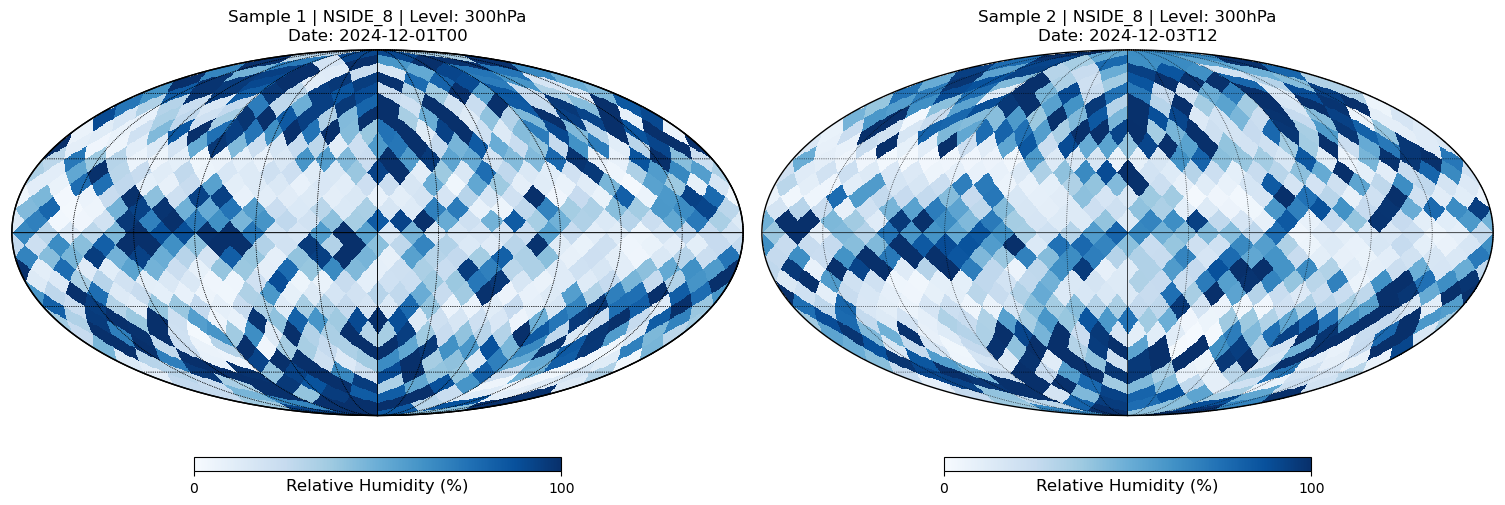

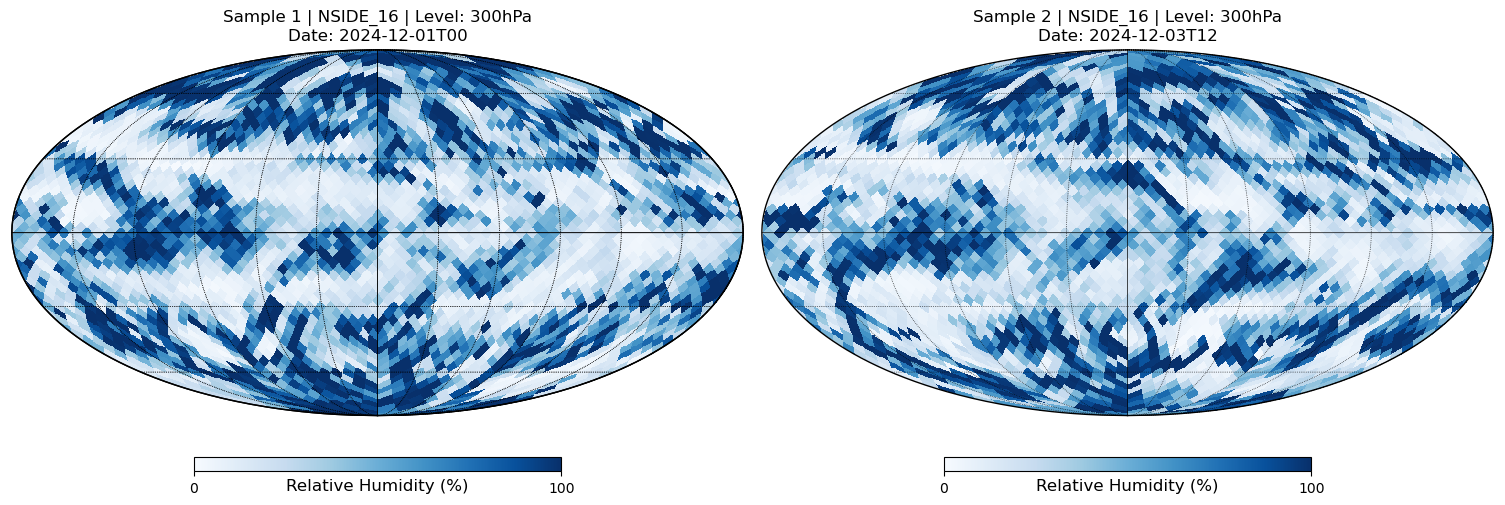

In [2]:
plot_zarr_samples("era5_humidity.zarr", nside_group="NSIDE_8", target_level = '300')
plot_zarr_samples("era5_humidity.zarr", nside_group="NSIDE_16", target_level = '300')

For a different pressure level, close to surface pressure:

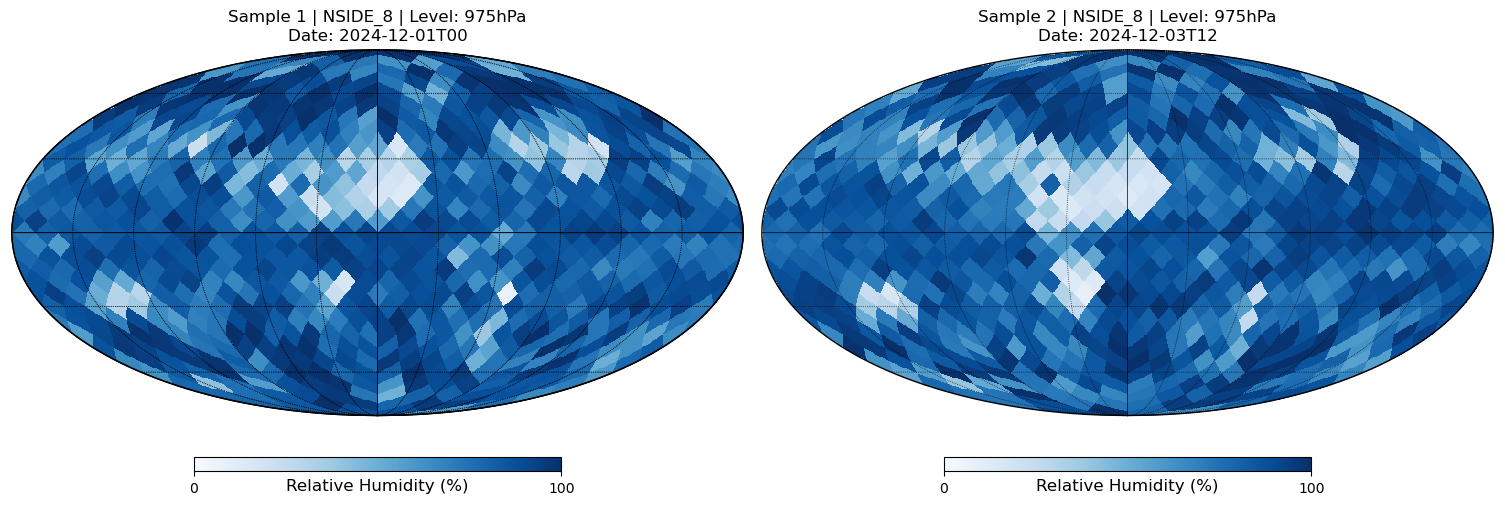

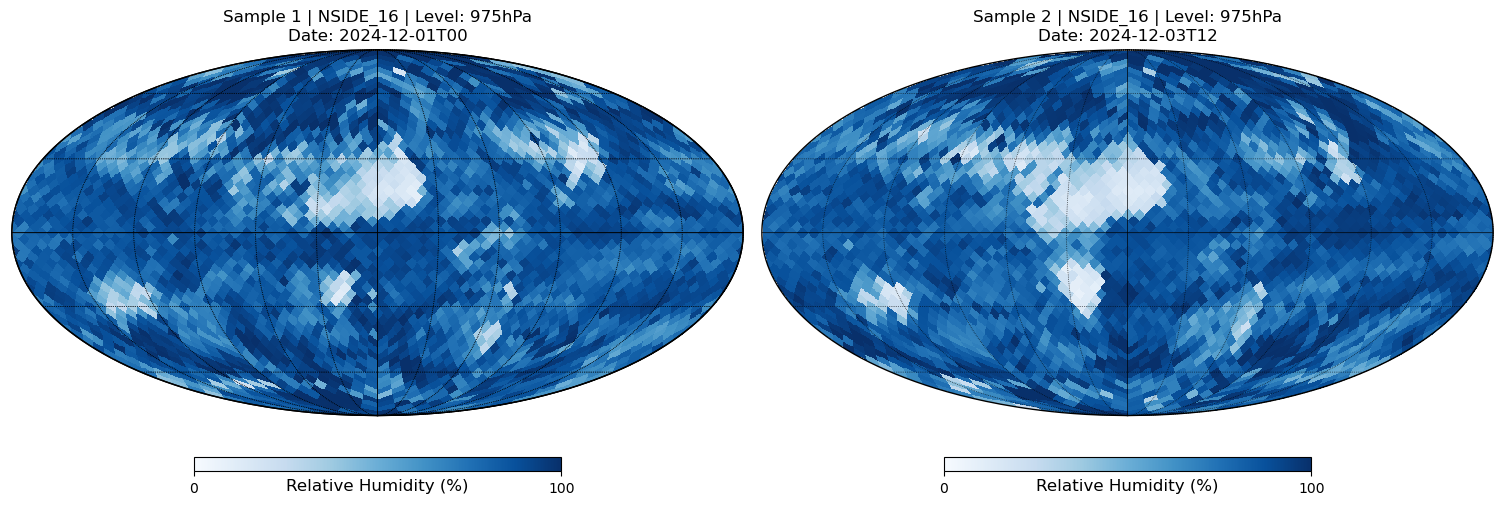

In [3]:
plot_zarr_samples("era5_humidity.zarr", nside_group="NSIDE_8", target_level = '975')
plot_zarr_samples("era5_humidity.zarr", nside_group="NSIDE_16", target_level = '975')